In [1]:
from neural_denoiser import BinDenoiser
from negbin import RecordGenerator
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
maxbins = None
denoiser = BinDenoiser(nblocks=24, ksize=5, filters=64)
inputs = tf.keras.Input(shape=(maxbins, 1))
outputs = denoiser(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [3]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
bin_denoiser (BinDenoiser)   (None, None, 1)           135125    
Total params: 135,125
Trainable params: 129,875
Non-trainable params: 5,250
_________________________________________________________________


In [9]:
model.load_weights("tmp.h5")

In [10]:
def lasso(x):
    nbins = tf.cast(tf.shape(x), tf.float32)[1]
    x = x * tf.math.sqrt(nbins)
    x = tf.reduce_mean(tf.math.abs(x))
    return x


def ridge(x):
    nbins = tf.cast(tf.shape(x), tf.float32)[1]
    x = tf.reduce_mean(x ** 2) * nbins
    return x


def tv(x):  
    x = tf.image.total_variation(x)
    x = tf.reduce_mean(x)
    return x

def tv2(x):
    x0 = x[:,:-1,:]
    x1 = x[:,1:,:]
    out = tf.reduce_sum((x1 - x0)**2, 1)
    out = tf.reduce_mean(out)
    return out

def tv_trend(x):
    x0 = x[:,:-1,:]
    x1 = x[:,1:,:]
    z = (x1 - x0)
    z0 = z[:,:-1,:]
    z1 = z[:,1:,:]
    out = tf.reduce_sum((z1 - z0)**2, 1)
    out = tf.reduce_mean(out)
    return out

def llhood(y, yhat):
    nbins = tf.cast(tf.shape(y), tf.float32)[1]
    loss = tf.reduce_mean((y - yhat)**2) * nbins
    return loss

def kl(y, yhat):
    x = - y * tf.math.log((yhat + 1e-12) / y)
    x = tf.math.reduce_sum(x, 1)
    loss = tf.math.reduce_mean(x)
    return loss


def my_loss(y, yhat):
    return tv_trend(yhat) + 5.0 * llhood(y, yhat) + 2.5 * tv2(yhat) + kl(y, yhat)

model.compile(optimizer=tf.keras.optimizers.Adam(
                learning_rate=1e-3,
                clipnorm=5.0),
              loss=my_loss)



In [11]:
def plot_test_case():
    data = generator.generate()
    h = np.arange(data['n_bins'])
    x = np.array(data['counts'], dtype=np.float32)
    x /= x.sum()
    y = data['signal_normalized']
    xinput = np.expand_dims(x, -1)
    xinput = np.expand_dims(xinput, 0)
    yhat = np.squeeze(model(tf.constant(xinput)).numpy())
    plt.figure(figsize=(10, 4))
    plt.bar(h, x, width=1)
    plt.plot(h, yhat, c="red")
    plt.plot(h, y, c="black")
    r, nc, noise_disp = data['rounding'], data['n_comps'], data['noise_dispersion']
    N, eps, sig_disp = data['n_bins'], data['noise_ratio'], data['signal_overdispersion']
    plt.title(f"round: {r}, ncomps: {nc}, noise_disp: {noise_disp:.2f}, noise: {eps:.2f}, sig_disp: {sig_disp:.2f}, nbins: {N}")
    return x, y, yhat

In [12]:
first_run = 0

sim 1/500000, loss: 0.1850, losses_av: 0.1850, tv: 0.00154, tv_trend: 0.00123,  shrink: 0.0189, ll: 0.0070, KL: 0.1272, nbins: 352


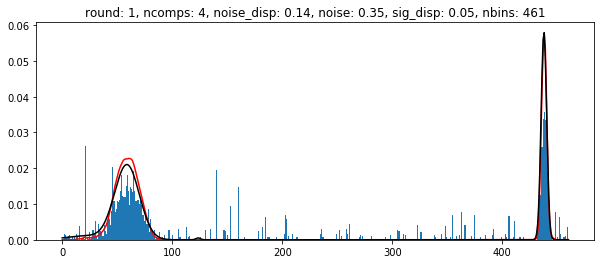

sim 10/500000, loss: 0.3830, losses_av: 0.1849, tv: 0.00155, tv_trend: 0.00125,  shrink: 0.0190, ll: 0.0070, KL: 0.1271, nbins: 84
sim 20/500000, loss: 0.1504, losses_av: 0.1850, tv: 0.00157, tv_trend: 0.00127,  shrink: 0.0191, ll: 0.0071, KL: 0.1270, nbins: 153
sim 30/500000, loss: 0.1986, losses_av: 0.1854, tv: 0.00158, tv_trend: 0.00128,  shrink: 0.0192, ll: 0.0071, KL: 0.1273, nbins: 441
sim 40/500000, loss: 0.1602, losses_av: 0.1853, tv: 0.00158, tv_trend: 0.00127,  shrink: 0.0192, ll: 0.0071, KL: 0.1272, nbins: 549
sim 50/500000, loss: 0.2815, losses_av: 0.1852, tv: 0.00160, tv_trend: 0.00129,  shrink: 0.0194, ll: 0.0072, KL: 0.1272, nbins: 510
sim 60/500000, loss: 0.1366, losses_av: 0.1850, tv: 0.00161, tv_trend: 0.00131,  shrink: 0.0194, ll: 0.0072, KL: 0.1270, nbins: 300
sim 70/500000, loss: 0.2269, losses_av: 0.1851, tv: 0.00164, tv_trend: 0.00134,  shrink: 0.0195, ll: 0.0072, KL: 0.1272, nbins: 547
sim 80/500000, loss: 0.1604, losses_av: 0.1846, tv: 0.00166, tv_trend: 0.0013

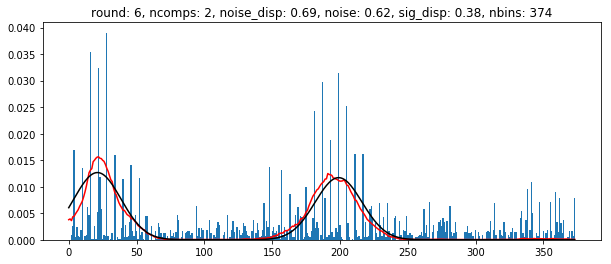

sim 110/500000, loss: 0.1432, losses_av: 0.1840, tv: 0.00170, tv_trend: 0.00142,  shrink: 0.0198, ll: 0.0072, KL: 0.1268, nbins: 100
sim 120/500000, loss: 0.1105, losses_av: 0.1841, tv: 0.00174, tv_trend: 0.00146,  shrink: 0.0199, ll: 0.0072, KL: 0.1268, nbins: 514
sim 130/500000, loss: 0.1500, losses_av: 0.1837, tv: 0.00175, tv_trend: 0.00148,  shrink: 0.0200, ll: 0.0072, KL: 0.1267, nbins: 364
sim 140/500000, loss: 0.0917, losses_av: 0.1834, tv: 0.00176, tv_trend: 0.00149,  shrink: 0.0201, ll: 0.0072, KL: 0.1264, nbins: 329
sim 150/500000, loss: 0.1435, losses_av: 0.1830, tv: 0.00178, tv_trend: 0.00150,  shrink: 0.0202, ll: 0.0072, KL: 0.1262, nbins: 161
sim 160/500000, loss: 0.2337, losses_av: 0.1826, tv: 0.00178, tv_trend: 0.00150,  shrink: 0.0203, ll: 0.0072, KL: 0.1259, nbins: 142
sim 170/500000, loss: 0.2067, losses_av: 0.1824, tv: 0.00178, tv_trend: 0.00150,  shrink: 0.0204, ll: 0.0072, KL: 0.1257, nbins: 286
sim 180/500000, loss: 0.1243, losses_av: 0.1821, tv: 0.00180, tv_tren

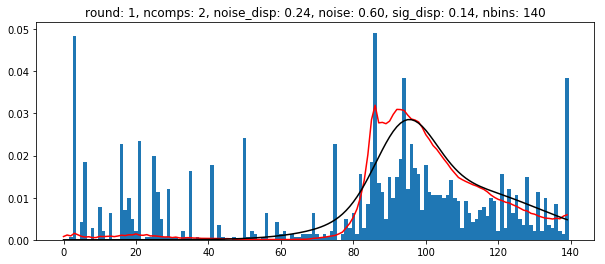

sim 210/500000, loss: 0.1928, losses_av: 0.1816, tv: 0.00184, tv_trend: 0.00156,  shrink: 0.0207, ll: 0.0073, KL: 0.1254, nbins: 227
sim 220/500000, loss: 0.0836, losses_av: 0.1809, tv: 0.00185, tv_trend: 0.00157,  shrink: 0.0207, ll: 0.0073, KL: 0.1251, nbins: 118
sim 230/500000, loss: 0.3042, losses_av: 0.1809, tv: 0.00188, tv_trend: 0.00160,  shrink: 0.0208, ll: 0.0073, KL: 0.1250, nbins: 167
sim 240/500000, loss: 0.1844, losses_av: 0.1808, tv: 0.00189, tv_trend: 0.00162,  shrink: 0.0210, ll: 0.0073, KL: 0.1249, nbins: 372
sim 250/500000, loss: 0.1410, losses_av: 0.1806, tv: 0.00189, tv_trend: 0.00162,  shrink: 0.0210, ll: 0.0073, KL: 0.1250, nbins: 151
sim 260/500000, loss: 0.3343, losses_av: 0.1807, tv: 0.00191, tv_trend: 0.00164,  shrink: 0.0211, ll: 0.0074, KL: 0.1250, nbins: 20
sim 270/500000, loss: 0.1197, losses_av: 0.1804, tv: 0.00192, tv_trend: 0.00165,  shrink: 0.0211, ll: 0.0074, KL: 0.1249, nbins: 275
sim 280/500000, loss: 0.1126, losses_av: 0.1802, tv: 0.00192, tv_trend

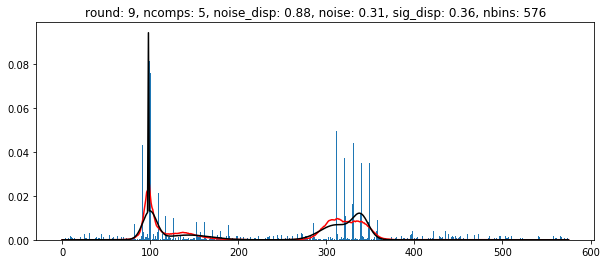

sim 310/500000, loss: 0.4170, losses_av: 0.1802, tv: 0.00194, tv_trend: 0.00168,  shrink: 0.0214, ll: 0.0075, KL: 0.1248, nbins: 168
sim 320/500000, loss: 0.2870, losses_av: 0.1801, tv: 0.00196, tv_trend: 0.00170,  shrink: 0.0214, ll: 0.0075, KL: 0.1247, nbins: 306
sim 330/500000, loss: 0.1773, losses_av: 0.1802, tv: 0.00197, tv_trend: 0.00172,  shrink: 0.0215, ll: 0.0075, KL: 0.1247, nbins: 88
sim 340/500000, loss: 0.0783, losses_av: 0.1797, tv: 0.00199, tv_trend: 0.00174,  shrink: 0.0215, ll: 0.0075, KL: 0.1245, nbins: 599
sim 350/500000, loss: 0.2493, losses_av: 0.1793, tv: 0.00198, tv_trend: 0.00174,  shrink: 0.0216, ll: 0.0075, KL: 0.1243, nbins: 107
sim 360/500000, loss: 0.1769, losses_av: 0.1791, tv: 0.00198, tv_trend: 0.00173,  shrink: 0.0216, ll: 0.0075, KL: 0.1243, nbins: 185
sim 370/500000, loss: 0.0925, losses_av: 0.1788, tv: 0.00199, tv_trend: 0.00174,  shrink: 0.0217, ll: 0.0075, KL: 0.1242, nbins: 559
sim 380/500000, loss: 0.1794, losses_av: 0.1786, tv: 0.00202, tv_trend

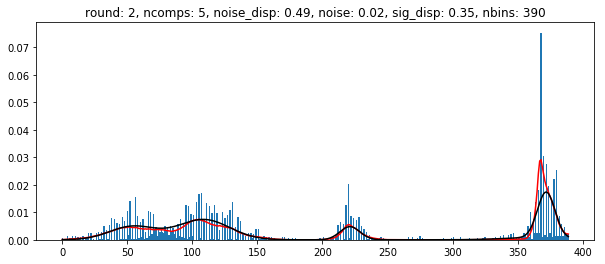

sim 410/500000, loss: 0.1131, losses_av: 0.1784, tv: 0.00206, tv_trend: 0.00179,  shrink: 0.0222, ll: 0.0076, KL: 0.1240, nbins: 480
sim 420/500000, loss: 0.0993, losses_av: 0.1781, tv: 0.00208, tv_trend: 0.00182,  shrink: 0.0222, ll: 0.0075, KL: 0.1238, nbins: 272
sim 430/500000, loss: 0.1009, losses_av: 0.1777, tv: 0.00208, tv_trend: 0.00182,  shrink: 0.0223, ll: 0.0075, KL: 0.1235, nbins: 360
sim 440/500000, loss: 0.1398, losses_av: 0.1776, tv: 0.00208, tv_trend: 0.00181,  shrink: 0.0223, ll: 0.0076, KL: 0.1235, nbins: 477


In [ ]:
generator = RecordGenerator(n_obs=(500, 5000),
                            n_bins=(10, 700),
                            noise_ratio=(0.01, 0.75),
                            noise_dispersion=(0.05, 1.0),
                            rounding=list(range(10)))
nsims = 500000
X = []
Y = []
losses = []
lamb = 0.001
losses_av = []

bsize = 32

for sim in range(nsims):
    n_bins = np.random.randint(10, 601)
    Xbatch = []
    Ybatch = []
    for _ in range(bsize):
        data = generator.generate(n_bins=n_bins)
        x = np.array(data['counts'], dtype=np.float32)
        x /= x.sum()
        Xbatch.append(x)
        y = data['signal_normalized']
        Ybatch.append(y)
    Xbatch = tf.constant(np.expand_dims(np.stack(Xbatch, 0), -1), tf.float32)
    Ybatch = tf.constant(np.expand_dims(np.stack(Ybatch, 0), -1), tf.float32)
    loss = model.train_on_batch(Xbatch, Ybatch)
    losses.append(float(loss))
    if sim == 0:
        yhat = model(Xbatch)
        if first_run == 0:
            first_run = 1
            loss_ = loss
            losses_av = [loss_]
            tv_ = tv2(yhat)
            tv_trend_ = tv_trend(yhat)
            kl_ = kl(Ybatch, yhat)
            shrink_ = ridge(yhat)
            ll_ = llhood(Ybatch, yhat)
        else:
            losses_av = [loss_]
    else:
        loss_ = lamb * losses[-1] + (1.0 - lamb) * losses_av[-1]
        losses_av.append(loss_)

    yhat = model(Xbatch)
    tv_ += lamb * (tv2(yhat) - tv_)
    tv_trend_ += lamb * (tv_trend(yhat) - tv_trend_)
    shrink_ += lamb * (ridge(yhat) - shrink_)
    ll_ += lamb * (llhood(Ybatch, yhat) - ll_)
    kl_ += lamb * (kl(Ybatch, yhat) - kl_)
        
    if sim == 0 or (sim + 1) % 10 == 0:
        print(f"sim {sim + 1}/{nsims}, loss: {losses[-1]:.4f}, ", end="")
        print(f"losses_av: {losses_av[-1]:.4f}, tv: {tv_:.5f}, tv_trend: {tv_trend_:.5f}, ", end="")
        print(f" shrink: {shrink_:.4f}, ll: {ll_:.4f}, KL: {kl_:.4f}, nbins: {n_bins}")
        
    loss_every = 500
    max_loss_range = 10000
    if (sim + 1) % loss_every == 0:
        plt.figure(figsize=(9, 4))
        n = len(losses_av)
        start = max(n - max_loss_range, 0) 
        plt.plot(range(start, n), losses_av[start:], c="red")
        plt.axvline(max(n - loss_every, 0), c="black")
        plt.show()

    if sim == 0 or (sim + 1) % 100 == 0:
        plot_test_case()
        plt.show()
        
    if (sim + 1) % 100 == 0:
        model.save_weights("tmp.h5")




In [ ]:

# plt.plot(losses)
plt.plot(losses_av, c="red")



In [ ]:
x, y, yhat = plot_test_case()

In [ ]:
plt.scatter(yhat, y)
plt.xlabel("prediction")
plt.ylabel("truth")
M = max(max(yhat), max(y))
plt.plot([0, M], [0, M], c="red")